# Medical Diagnosis using Bayes Nets

A drug company would like to introduce a drug to help patients with Alzheimer's. It is desirable to estimate $θ$, the proportion of the market share that this drug will capture. 
- The company interviews 100 people and 15 of them say that they will buy the drug. (This the observed data: n=100, observed=15) $->$ likelihood
- If in the past new drugs tend to capture a proportion between say .10 and .40 of the market, and if all values in between are assumed equally likely, then $θ ∼ Unif(0.10, 0.40)$ $->$ prior

### What is the traceplot of $\theta$ using Bayesian analysis to estimate the market share for the new drug?
- Sample 10000 draws
- Plot the traceplot

In [71]:
#!python --version
#!pip install pymc3==3.10
#!pip install arviz==0.10

In [1]:
import pymc3 as pm
import arviz as az

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8941240796612822, but should be close to 0.8. Try to increase the number of tuning steps.


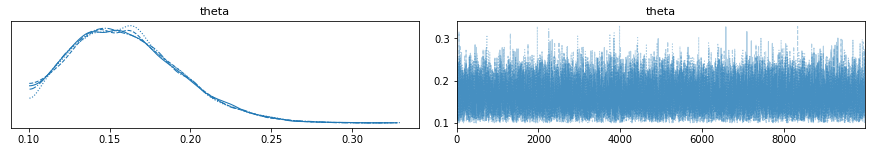

In [2]:
with pm.Model() as model:
    
    # Priors for unknown model parameters
    theta = pm.Uniform(name="theta", lower=0.1, upper=0.4)
    
    # Likelihood
    x = pm.Binomial(name="x", p=theta, n=100, observed=15)

    # Posterior
    # draw 10000 posterior samples
    trace = pm.sample(draws=10000, tune=1000, chains=4)
    
    # Plot the trace plot
    _ = pm.traceplot(trace, var_names=["theta"])

### Plot the posterior distribution plot of $ \theta $
- What is the mean posterior value?

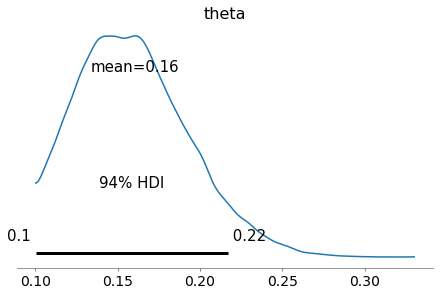

In [3]:
# Plot the posterior of trace
with model:
    az.plot_posterior(trace)


## Bayesian Network Analysis

In this part we will be analyzing medical diagnosis using Bayes Nets. The structure and the Conditional Probabability Distribution tables are shown in the figure below.

# ![MedicalDiagnosis](Med-diag-bnet.jpg)

- In the first few questions you will build the Bayes Net, set up the Conditional Probability Distribution tables, and associate the CPDs to the network.   
- These steps are extremely important and crucial. Make sure you do the set up correctly, as everything else depends on that.   

## Import Libraries

**Import the usual libraries for pandas and plotting, and sklearn.**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

In [5]:
#!pip install pgmpy
#!pip install torch

In [6]:
# import pgmpy
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

In [7]:
import sklearn
sklearn.__version__

'0.22.2.post1'



**Define the model structure.** 

You need to define the network by passing a list of edges. 

In [8]:
# Building model by passing a list of edges
model = BayesianModel([('Smokes', 'LungDisease'), ('LungDisease', 'ShortnessBreath'), ('LungDisease', 'ChestPain'), ('LungDisease', 'Cough'), ('Cold', 'Cough'), ('Cold', 'Fever')])



**Define individual CPDs**
- Define the CPDs using the state names of the variables. 

In [9]:
 # Defining Smokes CPD
cpd_Smokes = TabularCPD(variable='Smokes', variable_card=2, values=[[0.2], [0.8]], state_names={'Smokes' : ['T', 'F']})

In [10]:
# Defining LungDisease CPD
cpd_LungDisease = TabularCPD(variable='LungDisease', 
                             variable_card=2, 
                             values=[[0.1009, 0.001],
                                     [0.8991, 0.999]],
                             evidence=['Smokes'],
                             evidence_card=[2],
                            state_names={'Smokes' : ['T', 'F'], 'LungDisease' : ['T', 'F']})

In [11]:
# Defining ShortnessBreath CPD
cpd_ShortnessBreath = TabularCPD(variable='ShortnessBreath', 
                             variable_card=2, 
                             values=[[0.208, 0.01],
                                     [0.792, 0.99]],
                             evidence=['LungDisease'],
                             evidence_card=[2],
                            state_names={'LungDisease' : ['T', 'F'], 'ShortnessBreath' : ['T', 'F']})

In [12]:
# Defining ChestPain CPD
cpd_ChestPain = TabularCPD(variable='ChestPain', 
                             variable_card=2, 
                             values=[[0.208, 0.01],
                                     [0.792, 0.99]],
                             evidence=['LungDisease'],
                             evidence_card=[2],
                            state_names={'LungDisease' : ['T', 'F'], 'ChestPain' : ['T', 'F']})

In [13]:
# Defining Cough CPD
cpd_Cough = TabularCPD(variable='Cough', 
                             variable_card=2, 
                             values=[[0.7525, 0.505, 0.505, 0.01],
                                     [0.2475, 0.495, 0.495, 0.99]],
                             evidence=['LungDisease', 'Cold'],
                             evidence_card=[2,2],
                             state_names={'Cough' : ['T', 'F'],
                                          'LungDisease' : ['T', 'F'],
                                          'Cold' : ['T', 'F']})

In [14]:
# Defining Cold CPD
cpd_Cold = TabularCPD(variable='Cold', variable_card=2, values=[[0.02], [0.98]], state_names={'Cold' : ['T', 'F']})

In [15]:
# Defining Fever CPD
cpd_Fever = TabularCPD(variable='Fever', 
                             variable_card=2, 
                             values=[[0.307, 0.01],
                                     [0.693, 0.99]],
                             evidence=['Cold'],
                             evidence_card=[2],
                            state_names={'Cold' : ['T', 'F'], 'Fever' : ['T', 'F']})


#### Check that each of the CPDs are correct

In [16]:
cpd_Smokes

<TabularCPD representing P(Smokes:2) at 0x7f1073db48d0>

In [17]:
print(cpd_Smokes)

+-----------+-----+
| Smokes(T) | 0.2 |
+-----------+-----+
| Smokes(F) | 0.8 |
+-----------+-----+


In [18]:
cpd_LungDisease

<TabularCPD representing P(LungDisease:2 | Smokes:2) at 0x7f106e8e8e50>

In [19]:
print(cpd_LungDisease)

+----------------+-----------+-----------+
| Smokes         | Smokes(T) | Smokes(F) |
+----------------+-----------+-----------+
| LungDisease(T) | 0.1009    | 0.001     |
+----------------+-----------+-----------+
| LungDisease(F) | 0.8991    | 0.999     |
+----------------+-----------+-----------+


In [20]:
cpd_ShortnessBreath

<TabularCPD representing P(ShortnessBreath:2 | LungDisease:2) at 0x7f107404e110>

In [21]:
print(cpd_ShortnessBreath)

+--------------------+----------------+----------------+
| LungDisease        | LungDisease(T) | LungDisease(F) |
+--------------------+----------------+----------------+
| ShortnessBreath(T) | 0.208          | 0.01           |
+--------------------+----------------+----------------+
| ShortnessBreath(F) | 0.792          | 0.99           |
+--------------------+----------------+----------------+


In [22]:
cpd_ChestPain

<TabularCPD representing P(ChestPain:2 | LungDisease:2) at 0x7f1073da5810>

In [23]:
print(cpd_ChestPain)

+--------------+----------------+----------------+
| LungDisease  | LungDisease(T) | LungDisease(F) |
+--------------+----------------+----------------+
| ChestPain(T) | 0.208          | 0.01           |
+--------------+----------------+----------------+
| ChestPain(F) | 0.792          | 0.99           |
+--------------+----------------+----------------+


In [24]:
cpd_Cough

<TabularCPD representing P(Cough:2 | LungDisease:2, Cold:2) at 0x7f107404e090>

In [25]:
print(cpd_Cough)

+-------------+----------------+----------------+----------------+----------------+
| LungDisease | LungDisease(T) | LungDisease(T) | LungDisease(F) | LungDisease(F) |
+-------------+----------------+----------------+----------------+----------------+
| Cold        | Cold(T)        | Cold(F)        | Cold(T)        | Cold(F)        |
+-------------+----------------+----------------+----------------+----------------+
| Cough(T)    | 0.7525         | 0.505          | 0.505          | 0.01           |
+-------------+----------------+----------------+----------------+----------------+
| Cough(F)    | 0.2475         | 0.495          | 0.495          | 0.99           |
+-------------+----------------+----------------+----------------+----------------+


In [26]:
cpd_Cold

<TabularCPD representing P(Cold:2) at 0x7f1073db4410>

In [27]:
print(cpd_Cold)

+---------+------+
| Cold(T) | 0.02 |
+---------+------+
| Cold(F) | 0.98 |
+---------+------+


In [28]:
cpd_Fever

<TabularCPD representing P(Fever:2 | Cold:2) at 0x7f10649bc590>

In [29]:
print(cpd_Fever)

+----------+---------+---------+
| Cold     | Cold(T) | Cold(F) |
+----------+---------+---------+
| Fever(T) | 0.307   | 0.01    |
+----------+---------+---------+
| Fever(F) | 0.693   | 0.99    |
+----------+---------+---------+


## Q5 [5]
- Add the defined CPDs to the model (Associate the CPDs with the network)

In [30]:
# Associating the parameters with the model structure
model.add_cpds(cpd_Smokes, cpd_LungDisease, cpd_ShortnessBreath, cpd_ChestPain, cpd_Cough, cpd_Cold, cpd_Fever)

# Checking if the cpds are valid for the model
model.check_model()

True


#### The cardinality of each of the nodes is 2 - True or False?

In [31]:
model.get_cardinality('Smokes')

2

In [32]:
model.get_cardinality('LungDisease')

2

In [33]:
model.get_cardinality('ShortnessBreath')

2

In [34]:
model.get_cardinality('ChestPain')

2

In [35]:
model.get_cardinality('Cough')

2

In [36]:
model.get_cardinality('Cold')

2

In [37]:
model.get_cardinality('Fever')

2

As shown above, the cardinality of each of the nodes is 2 


#### Find the probability of each event hapenning using the variable elimination method
- $ P(Smokes) $
- $ P(Cold) $
- $ P(LungDisease) $
- $ P(ShortnessBreath) $
- $ P(ChestPain) $
- $ P(Fever) $
- $ P(Cough) $
- $ P(LungDisease|Smokes=True) $
- $ P(LungDisease|Cough=True) $
- $ P(ShortnessBreath|Smokes=True) $
- $ P(ChestPain|Fever=True) $

In [38]:
# Inference from bayesian models
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

In [39]:
# Computing the probability of Smokes
dist = infer.query(['Smokes'])
print(dist)

Eliminating: ShortnessBreath: 100%|██████████| 6/6 [00:00<00:00, 199.83it/s]

+-----------+---------------+
| Smokes    |   phi(Smokes) |
+===========+===============+
| Smokes(T) |        0.2000 |
+-----------+---------------+
| Smokes(F) |        0.8000 |
+-----------+---------------+


In [40]:
# Computing the probability of Cold
dist = infer.query(['Cold'])
print(dist)

Eliminating: ShortnessBreath: 100%|██████████| 6/6 [00:00<00:00, 415.02it/s]

+---------+-------------+
| Cold    |   phi(Cold) |
+=========+=============+
| Cold(T) |      0.0200 |
+---------+-------------+
| Cold(F) |      0.9800 |
+---------+-------------+


In [41]:
# Computing the probability of LungDisease
dist = infer.query(['LungDisease'])
print(dist)

Eliminating: ShortnessBreath: 100%|██████████| 6/6 [00:00<00:00, 428.92it/s]

+----------------+--------------------+
| LungDisease    |   phi(LungDisease) |
+================+====================+
| LungDisease(T) |             0.0210 |
+----------------+--------------------+
| LungDisease(F) |             0.9790 |
+----------------+--------------------+


In [42]:
# Computing the probability of ShortnessBreath
dist = infer.query(['ShortnessBreath'])
print(dist)

Eliminating: Cold: 100%|██████████| 6/6 [00:00<00:00, 274.22it/s]

+--------------------+------------------------+
| ShortnessBreath    |   phi(ShortnessBreath) |
+====================+========================+
| ShortnessBreath(T) |                 0.0142 |
+--------------------+------------------------+
| ShortnessBreath(F) |                 0.9858 |
+--------------------+------------------------+


In [43]:
# Computing the probability of ChestPain
dist = infer.query(['ChestPain'])
print(dist)

Eliminating: LungDisease: 100%|██████████| 6/6 [00:00<00:00, 315.65it/s]

+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.0142 |
+--------------+------------------+
| ChestPain(F) |           0.9858 |
+--------------+------------------+


In [44]:
# Computing the probability of Fever
dist = infer.query(['Fever'])
print(dist)

Eliminating: ShortnessBreath: 100%|██████████| 6/6 [00:00<00:00, 305.17it/s]

+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.0159 |
+----------+--------------+
| Fever(F) |       0.9841 |
+----------+--------------+


In [45]:
# Computing the probability of Cough
dist = infer.query(['Cough'])
print(dist)

Eliminating: LungDisease: 100%|██████████| 6/6 [00:00<00:00, 483.09it/s]

+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.0302 |
+----------+--------------+
| Cough(F) |       0.9698 |
+----------+--------------+


In [46]:
# Computing the conditional distribution of LungDisease when Smokes is True
print(infer.query(['LungDisease'], evidence={'Smokes': 'T'}))

Eliminating: ShortnessBreath: 100%|██████████| 5/5 [00:00<00:00, 822.74it/s]

+----------------+--------------------+
| LungDisease    |   phi(LungDisease) |
+================+====================+
| LungDisease(T) |             0.1009 |
+----------------+--------------------+
| LungDisease(F) |             0.8991 |
+----------------+--------------------+


In [47]:
# Computing the conditional distribution of LungDisease when Cough is True
print(infer.query(['LungDisease'], evidence={'Cough': 'T'}))

Eliminating: ShortnessBreath: 100%|██████████| 5/5 [00:00<00:00, 821.80it/s]

+----------------+--------------------+
| LungDisease    |   phi(LungDisease) |
+================+====================+
| LungDisease(T) |             0.3545 |
+----------------+--------------------+
| LungDisease(F) |             0.6455 |
+----------------+--------------------+


In [48]:
# Computing the conditional distribution of ShortnessBreath when Smokes is True
print(infer.query(['ShortnessBreath'], evidence={'Smokes': 'T'}))

Eliminating: Cold: 100%|██████████| 5/5 [00:00<00:00, 295.55it/s]

+--------------------+------------------------+
| ShortnessBreath    |   phi(ShortnessBreath) |
+====================+========================+
| ShortnessBreath(T) |                 0.0300 |
+--------------------+------------------------+
| ShortnessBreath(F) |                 0.9700 |
+--------------------+------------------------+


In [49]:
# Computing the conditional distribution of ChestPain when Fever is True
print(infer.query(['ChestPain'], evidence={'Fever': 'T'}))

Eliminating: LungDisease: 100%|██████████| 5/5 [00:00<00:00, 423.15it/s]

+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.0142 |
+--------------+------------------+
| ChestPain(F) |           0.9858 |
+--------------+------------------+


#### Are the following  true? If not, can you make them independent by including info on the parent?
1. Cough is independent from Fever. (Having knowledge about Fever does not change the probability of Cough) 
2. Fever is independent from Smokes. 
3. ChestPain is independent from Smokes.


##### 1. Cough is independent from Fever

In [50]:
dist = infer.query(['Cough'])
print(dist)

dist = infer.query(['Cough'], evidence={'Fever':'T'})
print(dist)

dist = infer.query(['Cough'], evidence={'Fever':'F'})
print(dist)

Eliminating: Cold: 100%|██████████| 5/5 [00:00<00:00, 519.41it/s]

+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.0302 |
+----------+--------------+
| Cough(F) |       0.9698 |
+----------+--------------+
+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.2091 |
+----------+--------------+
| Cough(F) |       0.7909 |
+----------+--------------+
+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.0273 |
+----------+--------------+
| Cough(F) |       0.9727 |
+----------+--------------+


- Fever does affect Cough -> Not independent
- However, given the parent of both Fever and Cough (Cold), they should be independent.

In [51]:
dist = infer.query(['Cough'], evidence={'Cold':'F', 'Fever':'T'})
print(dist)

dist = infer.query(['Cough'], evidence={'Cold':'F', 'Fever':'F'})
print(dist)

dist = infer.query(['Cough'], evidence={'Cold':'T', 'Fever':'T'})
print(dist)

dist = infer.query(['Cough'], evidence={'Cold':'T', 'Fever':'F'})
print(dist)

Eliminating: LungDisease: 100%|██████████| 4/4 [00:00<00:00, 503.44it/s]

+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.0204 |
+----------+--------------+
| Cough(F) |       0.9796 |
+----------+--------------+
+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.0204 |
+----------+--------------+
| Cough(F) |       0.9796 |
+----------+--------------+
+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.5102 |
+----------+--------------+
| Cough(F) |       0.4898 |
+----------+--------------+
+----------+--------------+
| Cough    |   phi(Cough) |
+==========+==============+
| Cough(T) |       0.5102 |
+----------+--------------+
| Cough(F) |       0.4898 |
+----------+--------------+


From the parent tables above, it shows that only when cold is observed and change in fever does not affect cough since cough is only dependent on cold.  

##### 2. Fever is independent from Smokes. 

In [52]:
dist = infer.query(['Fever'])
print(dist)

dist = infer.query(['Fever'], evidence={'Smokes':'T'})
print(dist)

dist = infer.query(['Fever'], evidence={'Smokes':'F'})
print(dist)

Eliminating: ShortnessBreath: 100%|██████████| 5/5 [00:00<00:00, 424.78it/s]

+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.0159 |
+----------+--------------+
| Fever(F) |       0.9841 |
+----------+--------------+
+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.0159 |
+----------+--------------+
| Fever(F) |       0.9841 |
+----------+--------------+
+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.0159 |
+----------+--------------+
| Fever(F) |       0.9841 |
+----------+--------------+


From the table above, it appears true that fever is indepentdent from smokes, since fever is independent of its non-descendents of smokes.

##### 3. ChestPain is independent from Smokes.

In [53]:
dist = infer.query(['ChestPain'])
print(dist)

dist = infer.query(['ChestPain'], evidence={'Smokes':'T'})
print(dist)

dist = infer.query(['ChestPain'], evidence={'Smokes':'F'})
print(dist)

Eliminating: LungDisease: 100%|██████████| 5/5 [00:00<00:00, 414.55it/s]

+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.0142 |
+--------------+------------------+
| ChestPain(F) |           0.9858 |
+--------------+------------------+
+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.0300 |
+--------------+------------------+
| ChestPain(F) |           0.9700 |
+--------------+------------------+
+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.0102 |
+--------------+------------------+
| ChestPain(F) |           0.9898 |
+--------------+------------------+


ChestPain is independent from Smokes -> Not independent. It increases from 1.42 % to 3% when smokes is involved.

Checking Smoke -> Lungdisease -> ChestPain below

In [54]:
dist = infer.query(['ChestPain'], evidence={'Smokes':'F', 'LungDisease':'T'})
print(dist)

dist = infer.query(['ChestPain'], evidence={'Smokes':'F', 'LungDisease':'F'})
print(dist)

dist = infer.query(['ChestPain'], evidence={'Smokes':'T', 'LungDisease':'T'})
print(dist)

dist = infer.query(['ChestPain'], evidence={'Smokes':'T', 'LungDisease':'F'})
print(dist)

Eliminating: ShortnessBreath: 100%|██████████| 4/4 [00:00<00:00, 638.91it/s]

+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.2080 |
+--------------+------------------+
| ChestPain(F) |           0.7920 |
+--------------+------------------+
+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.0100 |
+--------------+------------------+
| ChestPain(F) |           0.9900 |
+--------------+------------------+
+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.2080 |
+--------------+------------------+
| ChestPain(F) |           0.7920 |
+--------------+------------------+
+--------------+------------------+
| ChestPain    |   phi(ChestPain) |
+==============+==================+
| ChestPain(T) |           0.0100 |
+--------------+------------------+
| ChestPain(F) |           0.9900 |
+--------------+------------

It is possible in this case that ChestPain depends more on Lungdisease, its parent, than the impact of Smokes.

#### The probability distribution 
1. Does having the knowledge that the person is coughing increase the probability of lung disease?
2. Does having the knowledge that the person is coughing increase the probability that the person has Cold?
3. Does having the knowledge that the person is coughing increase the probability that there is Fever?
4. Does having the knowledge that the person is coughing increase the probability that there is Fever, given the person has Cold?
5. Does having the knowledge that the person has Fever increase the probability that there is Lung Disease?


##### 1. Does having the knowledge that the person is coughing increase the probability of lung disease? [5]

In [55]:
dist = infer.query(['LungDisease'])
print(dist)
dist = infer.query(['LungDisease'], evidence={'Cough': 'T'})
print(dist)

Eliminating: ShortnessBreath: 100%|██████████| 5/5 [00:00<00:00, 421.55it/s]

+----------------+--------------------+
| LungDisease    |   phi(LungDisease) |
+================+====================+
| LungDisease(T) |             0.0210 |
+----------------+--------------------+
| LungDisease(F) |             0.9790 |
+----------------+--------------------+
+----------------+--------------------+
| LungDisease    |   phi(LungDisease) |
+================+====================+
| LungDisease(T) |             0.3545 |
+----------------+--------------------+
| LungDisease(F) |             0.6455 |
+----------------+--------------------+


Having the knowledge that the person is coughing increases the probability of lung disease.

##### 2. Does having the knowledge that the person is coughing increase the probability that the person has Cold? [5]

In [56]:
dist = infer.query(['Cold'])
print(dist)
dist = infer.query(['Cold'], evidence={'Cough': 'T'})
print(dist)

Eliminating: LungDisease: 100%|██████████| 5/5 [00:00<00:00, 449.85it/s]

+---------+-------------+
| Cold    |   phi(Cold) |
+=========+=============+
| Cold(T) |      0.0200 |
+---------+-------------+
| Cold(F) |      0.9800 |
+---------+-------------+
+---------+-------------+
| Cold    |   phi(Cold) |
+=========+=============+
| Cold(T) |      0.3381 |
+---------+-------------+
| Cold(F) |      0.6619 |
+---------+-------------+


Having the knowledge that the person is coughing increases the probability of having cold.

##### 3. Does having the knowledge that the person is coughing increase the probability that there is Fever? [5]

In [57]:
dist = infer.query(['Fever'])
print(dist)
dist = infer.query(['Fever'], evidence={'Cough': 'T'})
print(dist)

Eliminating: Cold: 100%|██████████| 5/5 [00:00<00:00, 495.65it/s]

+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.0159 |
+----------+--------------+
| Fever(F) |       0.9841 |
+----------+--------------+
+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.1104 |
+----------+--------------+
| Fever(F) |       0.8896 |
+----------+--------------+


Having the knowledge that the person is coughing increases the probability of having fever.

##### 4. Does having the knowledge that the person is coughing increase the probability that there is Fever, given the person has Cold?

In [58]:
dist = infer.query(['Fever'])
print(dist)
dist = infer.query(['Fever'], evidence={'Cough': 'F', 'Cold': 'T'})
print(dist)
dist = infer.query(['Fever'], evidence={'Cough': 'T', 'Cold': 'T'})
print(dist)

Eliminating: LungDisease: 100%|██████████| 4/4 [00:00<00:00, 569.01it/s]

+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.0159 |
+----------+--------------+
| Fever(F) |       0.9841 |
+----------+--------------+
+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.3070 |
+----------+--------------+
| Fever(F) |       0.6930 |
+----------+--------------+
+----------+--------------+
| Fever    |   phi(Fever) |
+==========+==============+
| Fever(T) |       0.3070 |
+----------+--------------+
| Fever(F) |       0.6930 |
+----------+--------------+


Having the knowledge that the person is coughing does not increase the probability that there is Fever, given the person has Cold.

##### 5. Does having the knowledge that the person has Fever increase the probability that there is Lung Disease?

In [59]:
dist = infer.query(['LungDisease'])
print(dist)
dist = infer.query(['LungDisease'], evidence={'Fever': 'T'})
print(dist)

Eliminating: ShortnessBreath: 100%|██████████| 5/5 [00:00<00:00, 513.44it/s]

+----------------+--------------------+
| LungDisease    |   phi(LungDisease) |
+================+====================+
| LungDisease(T) |             0.0210 |
+----------------+--------------------+
| LungDisease(F) |             0.9790 |
+----------------+--------------------+
+----------------+--------------------+
| LungDisease    |   phi(LungDisease) |
+================+====================+
| LungDisease(T) |             0.0210 |
+----------------+--------------------+
| LungDisease(F) |             0.9790 |
+----------------+--------------------+


Having the knowledge that the person has Fever does not increase the probability that there is Lung Disease.

#### The most probable state 
1. What's the most probable state of Cough? 
2. What's the most probable state of Cough given Cold is True? 
3. What's the most probable state of Cough given Cold is True and Lung Disease is True?

##### 1. What's the most probable state of Cough? 

In [60]:
# Getting the most probable state of the variable (Q10) instead of calculating probability distribution (Q9)
infer.map_query(['Cough'])

Eliminating: LungDisease: 100%|██████████| 6/6 [00:00<00:00, 400.63it/s]


{'Cough': 'F'}

The most probable state of Cough is False.

##### 2. What's the most probable state of Cough given Cold is True? 

In [61]:
infer.map_query(['Cough'], evidence={'Cold': 'T'})

Eliminating: LungDisease: 100%|██████████| 5/5 [00:00<00:00, 391.22it/s]


{'Cough': 'T'}

The most probable state of Cough is True, given Cold is True.

##### 3. What's the most probable state of Cough given Cold is True and Lung Disease is True?

In [62]:
infer.map_query(['Cough'], evidence={'Cold': 'T', 'LungDisease': 'T'})

Eliminating: ShortnessBreath: 100%|██████████| 4/4 [00:00<00:00, 671.95it/s]


{'Cough': 'T'}

The most probable state of Cough is True, given Cold is True and Lung Disease is True

# Well done!